In [1]:
import numpy as np
import pandas as pd
import read_model_ID_toy as model
import calculate_cleavage_rate_toy as clv
import matplotlib.pylab as plt
import sys
sys.path.append('../')
sys.path.append('../../code_Boyle')
import Nucleaseq_data_processing as processing
reload(model)
reload(clv)
import seaborn as sns
sns.set_style('ticks')
current_colors = sns.color_palette()

### load experimental data

In [2]:
filename = 'WT_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'
path_to_data = '../../data_nucleaseq_Finkelsteinlab/targetE/'

xdata, ydata, yerr = processing.prepare_multiprocessing_combined('1',filename,'../../Data_Boyle/',path_to_data,True)

kclv = []
kon = []
i = 1
while i < 20+1:
    for a in range(len(xdata)):
        if len(xdata[a])==1 and xdata[a][0]==i:
            kclv.append(ydata[a][0][0])
            kon.append(np.log10(ydata[a][1][0]))
            i = i + 1
    
kclv.append(ydata[0][0][0])
kclv = np.array(kclv)
kon.append(np.log10(ydata[0][1][0]))
kon = np.array(kon)



k_double = np.zeros([20,20])
k_double_on = np.zeros([20,20])

for a in range(len(xdata)):
    if len(xdata[a])==2:
        i = xdata[a][0]
        j = xdata[a][1]
        k_double[j-1,i-1] = (ydata[a][0][0])
        if len(ydata[a][1]) > 0:
            k_double_on[j-1,i-1] = np.log10(ydata[a][1][0])
        else:
            k_double_on[j-1,i-1] = np.nan
        
k_double_df = pd.DataFrame(k_double, index=range(1, 21), columns=range(1, 21))
k_double_on_df = pd.DataFrame(k_double_on, index=range(1, 21), columns=range(1, 21))

### construct artificial parameter set and show landscape

C:\Users\stijn\Anaconda2\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


1.7705877625835293


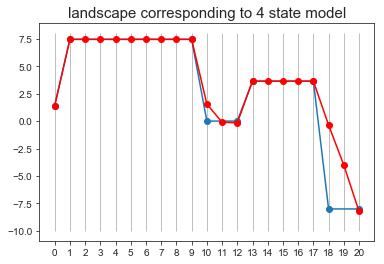

In [3]:
filename = 'fit_17_5_2019_sim_5.txt'
path = '../../fits_Stijn/17_5_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
T = data.loc[:,'Temperature']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter 25']
final_par_np = np.array(final_par.values)
model_id = 'four_state_model_clv'

parameters = np.zeros(26)
parameters[0] = 1.4
parameters[1] = 8.
parameters[2] = 6.045
parameters[3] = 3.637
parameters[4:24] = final_par_np[2:22]
#parameters[20:24] = 2.
parameters[-2] = final_par_np[-2]-1
parameters[-1] = final_par_np[-1]


epsilon, forward_rates = model.unpack_parameters(parameters,model_id)
epsilontemp = np.cumsum(np.append(1.4, -epsilon[1:5]))
epsilontemp = np.append(epsilontemp[0],np.append([epsilontemp[0] + epsilon[5],epsilontemp[0] + epsilon[5]],epsilontemp[1:]))
epsilontemp = np.append(epsilontemp[0:5],np.append([epsilontemp[4] + epsilon[6],epsilontemp[4] + epsilon[6]],epsilontemp[5:]))

plt.plot([0,1,9,10,12,13,17,18,20],epsilontemp,marker='o')
plt.vlines(range(0,21),-10,8,linewidth=0.5,color='grey')
plt.xticks(range(0,21),range(0,21));
plt.title('landscape corresponding to 4 state model',fontsize=15)

landscape = np.zeros(21)
landscape[0] = 1.389248 #PAM Boyle, minus PAM Boyle :)
landscape[1:10] = np.ones(9)*7.44538973 #median height
landscape[10:13] = [1.547533, -0.105180, -0.153215] #well defined dip, from Boyle
landscape[13:18] = np.ones(5)*3.6374928 #median height
landscape[18:21] = [-0.361180,-4.009278,-8.223548] #well defined second dip, from Boyle

plt.plot(range(0,21),landscape,marker='o',color='red')

print forward_rates[1]*np.exp(-epsilon[6])

Text(34,0.5,'mismatch 2')

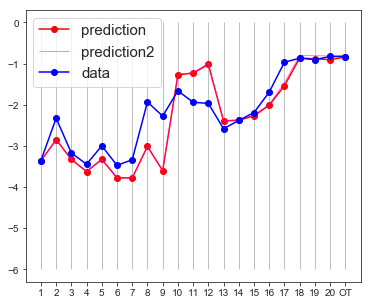

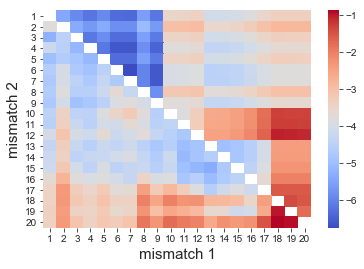

In [7]:
k = np.zeros(21)
for i in range(1,21):
    mismatch_positions = [i]
    k[i-1] = np.log10(clv.calc_cleavage_rate_fast(parameters,model_id,mismatch_positions))
k[-1] = np.log10(clv.calc_cleavage_rate_fast(parameters,model_id,[]))

k2 = np.zeros(21)
for i in range(1,21):
    mismatch_positions = [i]
    k2[i-1] = np.log10(clv.calc_cleavage_rate_slow(parameters,model_id,mismatch_positions))
k2[-1] = np.log10(clv.calc_cleavage_rate_slow(parameters,model_id,[]))

    
plt.figure(figsize=[6,5])
plt.plot(range(1,22),k,marker='o',color='red')
plt.plot(range(1,22),k2,color='magenta',linewidth=0.5)
plt.xticks(range(1,22),range(1,21)+['OT']);
plt.vlines(range(1,22),-6,0,linewidth=0.5,color='grey')
plt.plot(range(1,22),kclv,marker='o',color='b')
plt.legend(['prediction','prediction2','data'],fontsize=15)

k_double = np.zeros([20,20])
for i in range(1,20):
    for j in range(i+1,21):
        mismatch_positions = [i,j]
        k_double[i-1][j-1] = np.log10(clv.calc_cleavage_rate_fast(parameters,model_id,mismatch_positions))
        
k_df = pd.DataFrame(k_double, index=range(1, 21), columns=range(1, 21))
k_df = k_df + k_double_df
for i in range(1,21):
    k_df[i].loc[i]=np.nan
    
plt.figure()
sns.heatmap(k_df, cmap='coolwarm', cbar=True)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)

In [87]:
chi = 0.0

perfectClv = np.float(len(ydata[0]))
singleClv = 0.0
doubleClv = 0.0
for i in range(len(xdata)):
    if len(xdata[i])==1:
        singleClv += len(ydata[i])
    if len(xdata[i])==2:
        doubleClv += len(ydata[i])

chi_weights = [1/perfectClv,1/singleClv,1/doubleClv]

for i in range(len(xdata)):
    mismatch = xdata[i]
    chi += clv.calc_chi_squared(parameters,mismatch,ydata[i][0],yerr[i][0],chi_weights,False,model_id)
    
print chi

752.4666210002226


Text(34,0.5,'mismatch 2')

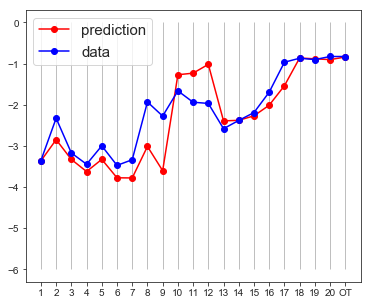

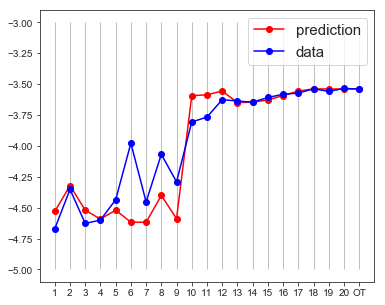

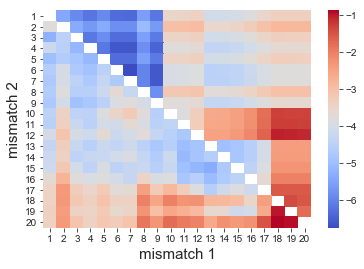

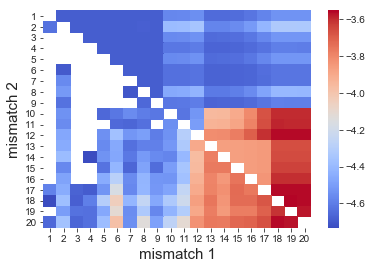

In [9]:
model_id = 'four_state_model_clv+four_state_model_on'
parameters_com = np.append(np.append([1.4],parameters[0:-2]),np.append([-2.4],parameters[-2:]))

k = np.zeros(21)
k2 = np.zeros(21)
for i in range(1,21):
    mismatch_positions = [i]
    k[i-1],k2[i-1] = np.log10(clv.calc_clv_on(parameters_com,model_id,mismatch_positions))
k[-1],k2[-1] = np.log10(clv.calc_clv_on(parameters_com,model_id,[]))
    
plt.figure(figsize=[6,5])
plt.plot(range(1,22),k,marker='o',color='red')
plt.xticks(range(1,22),range(1,21)+['OT']);
plt.vlines(range(1,22),-6,0,linewidth=0.5,color='grey')
plt.plot(range(1,22),kclv,marker='o',color='b')
plt.legend(['prediction','data'],fontsize=15)

plt.figure(figsize=[6,5])
plt.plot(range(1,22),k2,marker='o',color='red')
plt.xticks(range(1,22),range(1,21)+['OT']);
plt.vlines(range(1,22),-5,-3,linewidth=0.5,color='grey')
plt.plot(range(1,22),kon,marker='o',color='b')
plt.legend(['prediction','data'],fontsize=15)

k_double = np.zeros([20,20])
k_double2 = np.zeros([20,20])
for i in range(1,20):
    for j in range(i+1,21):
        mismatch_positions = [i,j]
        k_double[i-1][j-1],k_double2[i-1][j-1] = np.log10(clv.calc_clv_on(parameters_com,model_id,mismatch_positions))
        
k_df = pd.DataFrame(k_double, index=range(1, 21), columns=range(1, 21))
k_on_df = pd.DataFrame(k_double2, index=range(1, 21), columns=range(1, 21))

k_df = k_df + k_double_df
k_on_df = k_on_df + k_double_on_df
for i in range(1,21):
    k_df[i].loc[i]=np.nan
    k_on_df[i].loc[i]=np.nan
    
plt.figure()
sns.heatmap(k_df, cmap='coolwarm', cbar=True)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)

plt.figure()
sns.heatmap(k_on_df, cmap='coolwarm', cbar=True)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)

In [ ]:
print calc_cleavage_rate(parameters,model_id,[11])
print calc_cleavage_rate2(parameters,model_id,[11])

In [26]:
def calc_cleavage_rate(parameters,model_id,mismatch_positions):
    
    epsilon,rates = model.unpack_parameters(parameters,model_id)
    if type(mismatch_positions)==type([]):
            mismatch_positions = np.array(mismatch_positions)

    new_epsilon = epsilon.copy()        
    energies_OT = -1*new_epsilon[0:5]
    energies_OT[0] *= -1 #PAM, I, 0, R, 0
    barrier1 = new_epsilon[5]
    barrier2 = new_epsilon[6]

    for i in mismatch_positions:
        if i < 10: #mismatch in the first barrier
            energies_OT[1] += new_epsilon[6+i]
            barrier1 += new_epsilon[6+i]
        elif i < 13: #mismatch in first flat part
            energies_OT[2] += new_epsilon[6+i]
        elif i < 18: #mismatch in second barrier
            energies_OT[3] += new_epsilon[6+i]
            barrier2 += new_epsilon[6+i]
        elif i <21: #mismatch in last flat part
            energies_OT[4] += new_epsilon[6+i]

    rates_OT = rates.copy()
    rates_OT[1] *= np.exp(-barrier1)
    rates_OT[2] *= np.exp(-energies_OT[2])
    rates_OT[3] *= np.exp(-barrier2)
    rates_OT[4] *= np.exp(-energies_OT[4])

    backward_OT = np.zeros(len(rates_OT))
    backward_OT[0] = 0.0 #no rate backward from solution
    backward_OT[1] = rates_OT[0]*np.exp(energies_OT[0]) #backward rate from PAM
    backward_OT[2] = rates_OT[1]*np.exp(energies_OT[1]) #backward rate over first barrier
    backward_OT[3] = rates_OT[2]*np.exp(energies_OT[2]) #backward rate over flat part
    backward_OT[4] = rates_OT[3]*np.exp(energies_OT[3]) #backward rate over second barrier
    backward_OT[5] = rates_OT[4]*np.exp(energies_OT[4]) #backward rate over flat part
    
    #combined rates
    forward_combined = np.zeros(4)
    forward_combined[0] = rates_OT[0]
    forward_combined[1] = (rates_OT[1]*rates_OT[2])/(rates_OT[1] + backward_OT[2] +rates_OT[2])
    forward_combined[2] = (rates_OT[3]*rates_OT[4])/(rates_OT[3] + backward_OT[4] +rates_OT[4])
    forward_combined[3] = rates_OT[5]

    backward_combined = np.zeros(4)
    backward_combined[0] = backward_OT[0]
    backward_combined[1] = backward_OT[1]
    backward_combined[2] = (backward_OT[3]*backward_OT[2])/(backward_OT[3] + rates_OT[2] + backward_OT[2])
    backward_combined[3] = (backward_OT[5]*backward_OT[4])/(backward_OT[5] + rates_OT[4] + backward_OT[4])
    
    diagonal1 = -(forward_combined + backward_combined)
    diagonal2 = backward_combined[1:]
    diagonal3 = forward_combined[:-1]
    # rate_matrix = np.zeros((len(forward_rates), len(forward_rates)))  # Build the matrix

    rate_matrix = np.diag(diagonal1, k=0) + np.diag(diagonal2, k=1) + np.diag(diagonal3, k=-1)

    M = -1 * rate_matrix
    Minv = np.linalg.inv(M)
    vec = np.ones(len(Minv))
    everything_unbound = np.array([1.0] + [0.0] * (3))
    MFPT = vec.dot(Minv.dot(everything_unbound))
    k = 1/MFPT
    
    return k

In [63]:
def calc_cleavage_rate2(parameters,model_id,mismatch_positions):
    
    epsilon,rates = model.unpack_parameters(parameters,model_id)
    if type(mismatch_positions)==type([]):
            mismatch_positions = np.array(mismatch_positions)

    new_epsilon = epsilon.copy()        
    energies_OT = -1*new_epsilon[0:5]
    energies_OT[0] *= -1 #PAM, I, 0, R, 0
    barrier1 = new_epsilon[5]
    barrier2 = new_epsilon[6]

    rates_OT = rates.copy()
    rates_OT[1] *= np.exp(-barrier1)
    rates_OT[2] *= np.exp(-energies_OT[2])
    rates_OT[3] *= np.exp(-barrier2)
    rates_OT[4] *= np.exp(-energies_OT[4])
    
    for i in mismatch_positions:
        if i < 10: #mismatch in the first barrier
            rates_OT[1] *= np.exp(-new_epsilon[6+i])
        elif i < 13: #mismatch in first flat part
            rates_OT[2] *= np.exp(-new_epsilon[6+i])
        elif i < 18: #mismatch in second barrier
            rates_OT[3] *= np.exp(-new_epsilon[6+i])
            barrier2 += new_epsilon[6+i]
        elif i <21: #mismatch in last flat part
            rates_OT[4] *= np.exp(-new_epsilon[6+i])

    backward_OT = np.zeros(len(rates_OT))
    backward_OT[0] = 0.0 #no rate backward from solution
    backward_OT[1] = rates_OT[0]*np.exp(energies_OT[0]) #backward rate from PAM
    backward_OT[2] = rates_OT[1]*np.exp(energies_OT[1]) #backward rate over first barrier
    backward_OT[3] = rates_OT[2]*np.exp(energies_OT[2]) #backward rate over flat part
    backward_OT[4] = rates_OT[3]*np.exp(energies_OT[3]) #backward rate over second barrier
    backward_OT[5] = rates_OT[4]*np.exp(energies_OT[4]) #backward rate over flat part

    #combined rates
    forward_combined = np.zeros(4)
    forward_combined[0] = rates_OT[0]
    forward_combined[1] = (rates_OT[1]*rates_OT[2])/(rates_OT[1] + backward_OT[2] +rates_OT[2])
    forward_combined[2] = (rates_OT[3]*rates_OT[4])/(rates_OT[3] + backward_OT[4] +rates_OT[4])
    forward_combined[3] = rates_OT[5]

    backward_combined = np.zeros(4)
    backward_combined[0] = backward_OT[0]
    backward_combined[1] = backward_OT[1]
    backward_combined[2] = (backward_OT[3]*backward_OT[2])/(backward_OT[3] + rates_OT[2] + backward_OT[2])
    backward_combined[3] = (backward_OT[5]*backward_OT[4])/(backward_OT[5] + rates_OT[4] + backward_OT[4])

    diagonal1 = -(forward_combined + backward_combined)
    diagonal2 = backward_combined[1:]
    diagonal3 = forward_combined[:-1]
    # rate_matrix = np.zeros((len(forward_rates), len(forward_rates)))  # Build the matrix

    rate_matrix = np.diag(diagonal1, k=0) + np.diag(diagonal2, k=1) + np.diag(diagonal3, k=-1)

    M = -1 * rate_matrix
    Minv = np.linalg.inv(M)
    vec = np.ones(len(Minv))
    everything_unbound = np.array([1.0] + [0.0] * (3))
    MFPT = vec.dot(Minv.dot(everything_unbound))
    k = 1/MFPT
    
    return k

#### On-target cleavage rate using four state model

In [ ]:
if type(mismatch_positions)==type([]):
        mismatch_positions = np.array(mismatch_positions)

new_epsilon = epsilon.copy()        
energies_OT = -1*new_epsilon[0:5]
energies_OT[0] *= -1 #PAM, I, 0, R, 0
barrier1 = new_epsilon[5]
barrier2 = new_epsilon[6]

print 'energies'
print energies_OT
print ''
print 'barriers'
print barrier1
print barrier2
print ''

energies_MM = energies_OT.copy()
#for i in mismatch_positions:
#    if i < 10: #mismatch in the first barrier
#        energies_MM[1] += new_epsilon[4+i]
#        energies_MM[2] += new_epsilon[4+i]
#        barrier1 += new_epsilon[4+i]

rates_OT = rates.copy()
rates_OT[1] *= np.exp(-barrier1)
rates_OT[2] *= np.exp(-energies_OT[2])
rates_OT[3] *= np.exp(-barrier2)
rates_OT[4] *= np.exp(-energies_OT[4])

print 'rates'
print rates_OT

backward_OT = np.zeros(len(rates_OT))
backward_OT[0] = 0.0 #no rate backward from solution
backward_OT[1] = rates_OT[0]*np.exp(energies_OT[0]) #backward rate from PAM
backward_OT[2] = rates_OT[1]*np.exp(energies_OT[1]) #backward rate over first barrier
backward_OT[3] = rates_OT[2]*np.exp(energies_OT[2]) #backward rate over flat part
backward_OT[4] = rates_OT[3]*np.exp(energies_OT[3]) #backward rate over second barrier
backward_OT[5] = rates_OT[4]*np.exp(energies_OT[4]) #backward rate over flat part

print backward_OT
print ''

#combined rates
forward_combined = np.zeros(4)
forward_combined[0] = rates_OT[0]
forward_combined[1] = (rates_OT[1]*rates_OT[2])/(rates_OT[1] + backward_OT[2] +rates_OT[2])
forward_combined[2] = (rates_OT[3]*rates_OT[4])/(rates_OT[3] + backward_OT[4] +rates_OT[4])
forward_combined[3] = rates_OT[5]

backward_combined = np.zeros(4)
backward_combined[0] = backward_OT[0]
backward_combined[1] = backward_OT[1]
backward_combined[2] = (backward_OT[3]*backward_OT[2])/(backward_OT[3] + rates_OT[2] + backward_OT[2])
backward_combined[3] = (backward_OT[5]*backward_OT[4])/(backward_OT[5] + rates_OT[4] + backward_OT[4])

print 'combined rates'
print forward_combined
print backward_combined
print ''

diagonal1 = -(forward_combined + backward_combined)
diagonal2 = backward_combined[1:]
diagonal3 = forward_combined[:-1]
# rate_matrix = np.zeros((len(forward_rates), len(forward_rates)))  # Build the matrix

rate_matrix = np.diag(diagonal1, k=0) + np.diag(diagonal2, k=1) + np.diag(diagonal3, k=-1)

print 'matrix'
print rate_matrix
print ''

M = -1 * rate_matrix
Minv = np.linalg.inv(M)
vec = np.ones(len(Minv))
everything_unbound = np.array([1.0] + [0.0] * (3))
MFPT = vec.dot(Minv.dot(everything_unbound))
k = 1/MFPT

print 'prediction'
print k

In [ ]:
k = np.zeros(20)
for i in range(1,21):
    mismatch_positions = [i]

    if type(mismatch_positions)==type([]):
            mismatch_positions = np.array(mismatch_positions)

    new_epsilon = epsilon.copy()        
    energies_OT = -1*new_epsilon[0:5]
    energies_OT[0] *= -1 #PAM, I, 0, R, 0
    barrier1 = new_epsilon[5]
    barrier2 = new_epsilon[6]

    for i in mismatch_positions:
        if i < 10: #mismatch in the first barrier
            energies_OT[1] += new_epsilon[6+i]
            barrier1 += new_epsilon[6+i]
        elif i < 13: #mismatch in first flat part
            energies_OT[2] += new_epsilon[6+i]
        elif i < 18: #mismatch in second barrier
            energies_OT[3] += new_epsilon[6+i]
            barrier2 += new_epsilon[6+i]
        elif i <21: #mismatch in last flat part
            energies_OT[4] += new_epsilon[6+i]

    rates_OT = rates.copy()
    rates_OT[1] *= np.exp(-barrier1)
    rates_OT[2] *= np.exp(-energies_OT[2])
    rates_OT[3] *= np.exp(-barrier2)
    rates_OT[4] *= np.exp(-energies_OT[4])

    backward_OT = np.zeros(len(rates_OT))
    backward_OT[0] = 0.0 #no rate backward from solution
    backward_OT[1] = rates_OT[0]*np.exp(energies_OT[0]) #backward rate from PAM
    backward_OT[2] = rates_OT[1]*np.exp(energies_OT[1]) #backward rate over first barrier
    backward_OT[3] = rates_OT[2]*np.exp(energies_OT[2]) #backward rate over flat part
    backward_OT[4] = rates_OT[3]*np.exp(energies_OT[3]) #backward rate over second barrier
    backward_OT[5] = rates_OT[4]*np.exp(energies_OT[4]) #backward rate over flat part

    #combined rates
    forward_combined = np.zeros(4)
    forward_combined[0] = rates_OT[0]
    forward_combined[1] = (rates_OT[1]*rates_OT[2])/(rates_OT[1] + backward_OT[2] +rates_OT[2])
    forward_combined[2] = (rates_OT[3]*rates_OT[4])/(rates_OT[3] + backward_OT[4] +rates_OT[4])
    forward_combined[3] = rates_OT[5]

    backward_combined = np.zeros(4)
    backward_combined[0] = backward_OT[0]
    backward_combined[1] = backward_OT[1]
    backward_combined[2] = (backward_OT[3]*backward_OT[2])/(backward_OT[3] + rates_OT[2] + backward_OT[2])
    backward_combined[3] = (backward_OT[5]*backward_OT[4])/(backward_OT[5] + rates_OT[4] + backward_OT[4])

    diagonal1 = -(forward_combined + backward_combined)
    diagonal2 = backward_combined[1:]
    diagonal3 = forward_combined[:-1]
    # rate_matrix = np.zeros((len(forward_rates), len(forward_rates)))  # Build the matrix

    rate_matrix = np.diag(diagonal1, k=0) + np.diag(diagonal2, k=1) + np.diag(diagonal3, k=-1)

    M = -1 * rate_matrix
    Minv = np.linalg.inv(M)
    vec = np.ones(len(Minv))
    everything_unbound = np.array([1.0] + [0.0] * (3))
    MFPT = vec.dot(Minv.dot(everything_unbound))
    k[i-1] = 1/MFPT

print k
plt.figure(figsize=[6,5])
plt.semilogy(range(1,21),k,marker='o',color='red')
plt.xticks(range(1,21),range(1,21));
plt.vlines(range(1,21),10**-3,1,linewidth=0.5,color='grey')